In [9]:
import pandas as pd
import numpy as np

stocks = pd.read_csv("data/stocks_ti.csv")

import warnings

warnings.filterwarnings("ignore")

### Classifiers

I'm going to run Logistic Regression, Random Forest, and XGBoost classifiers on the data. Each model will be evaluated on the following datasets:
1. Previous days SPY returns
2. Previous subset plus previous days sector ETFs returns
3. Previous subset plus sentiment scores
4. Data from 2. plus technical indicators
5. Full dataset comprising sector ETFs, sentiment scores, and technical indicators

The previous process will be iterated trying to predict 1 day, 5 day, 13 day and 21 day returns.

In [ ]:
from utils import prep_classifier_data, feature_type_map

fm = feature_type_map(stocks)
columns1 = list(set(fm["spy_returns"]))
columns2 = list(set(fm["returns"]))
columns3 = list(set(fm["returns"] + fm["sentiment"]))
columns4 = list(set(fm["returns"] + fm["technical"]))
columns5 = stocks.columns

# dictionary to store tuple of (pred, confusion_matrix, classifier) for each day, for each feature type, for each model
models_key = {
    "logistic_regression": {
        "spy_returns": {1: None, 5: None, 13: None, 21: None},
        "sector_returns": {1: None, 5: None, 13: None, 21: None},
        "sector_returns_sentiment": {1: None, 5: None, 13: None, 21: None},
        "sector_returns_technical": {1: None, 5: None, 13: None, 21: None},
        "all_features": {1: None, 5: None, 13: None, 21: None},
    },
    "random_forest": {
        "spy_returns": {1: None, 5: None, 13: None, 21: None},
        "sector_returns": {1: None, 5: None, 13: None, 21: None},
        "sector_returns_sentiment": {1: None, 5: None, 13: None, 21: None},
        "sector_returns_technical": {1: None, 5: None, 13: None, 21: None},
        "all_features": {1: None, 5: None, 13: None, 21: None},
    },
    "xgboost": {
        "spy_returns": {1: None, 5: None, 13: None, 21: None},
        "sector_returns": {1: None, 5: None, 13: None, 21: None},
        "sector_returns_sentiment": {1: None, 5: None, 13: None, 21: None},
        "sector_returns_technical": {1: None, 5: None, 13: None, 21: None},
        "all_features": {1: None, 5: None, 13: None, 21: None},
    },
}

# loop through each day and each feature type
for i, day_no in enumerate([1, 5, 13, 21]):
    for j, features in enumerate([columns1, columns2, columns3, columns4, columns5]):
        features_type = [
            "spy_returns",
            "sector_returns",
            "sector_returns_sentiment",
            "sector_returns_technical",
            "all_features",
        ][j]

        # prep data
        X_train, X_test, y_train, y_test = prep_classifier_data(
            stocks[features].copy(), day_no
        )

        ## models
        from utils import (
            logistic_regression,
            random_forest_classifier,
            xgboost_classifier,
        )

        # logistic regression
        print(f"Logistic Regression on {day_no} day(s) with {features_type}...")
        models_key["logistic_regression"][features_type][day_no] = logistic_regression(
            X_train, X_test, y_train, y_test
        )

        # random forest
        print(f"Random Forest on {day_no} day(s) with {features_type}...")
        models_key["random_forest"][features_type][day_no] = random_forest_classifier(
            X_train, X_test, y_train, y_test
        )

        # xgboost
        print(f"XGBoost on {day_no} day(s) with {features_type}...")
        models_key["xgboost"][features_type][day_no] = xgboost_classifier(
            X_train, X_test, y_train, y_test
        )

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


def plot_all_confusion_matrices(feature_types_dict, title):
    fig, axes = plt.subplots(5, 4, figsize=(15, 20))
    fig.suptitle(title, fontsize=16)

    for i, (feature_type, days_dict) in enumerate(feature_types_dict.items()):
        for j, (days, results) in enumerate(days_dict.items()):
            if results is not None:
                cm = results[1]
                disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                disp.plot(
                    ax=axes[i, j], cmap="Blues", values_format=".0f", colorbar=False
                )
                axes[i, j].set_title(
                    f"Feature type: {feature_type} \n Predicting {days} day(s) return",
                    fontsize=10,
                )

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave some space at the top for the title
    plt.show()

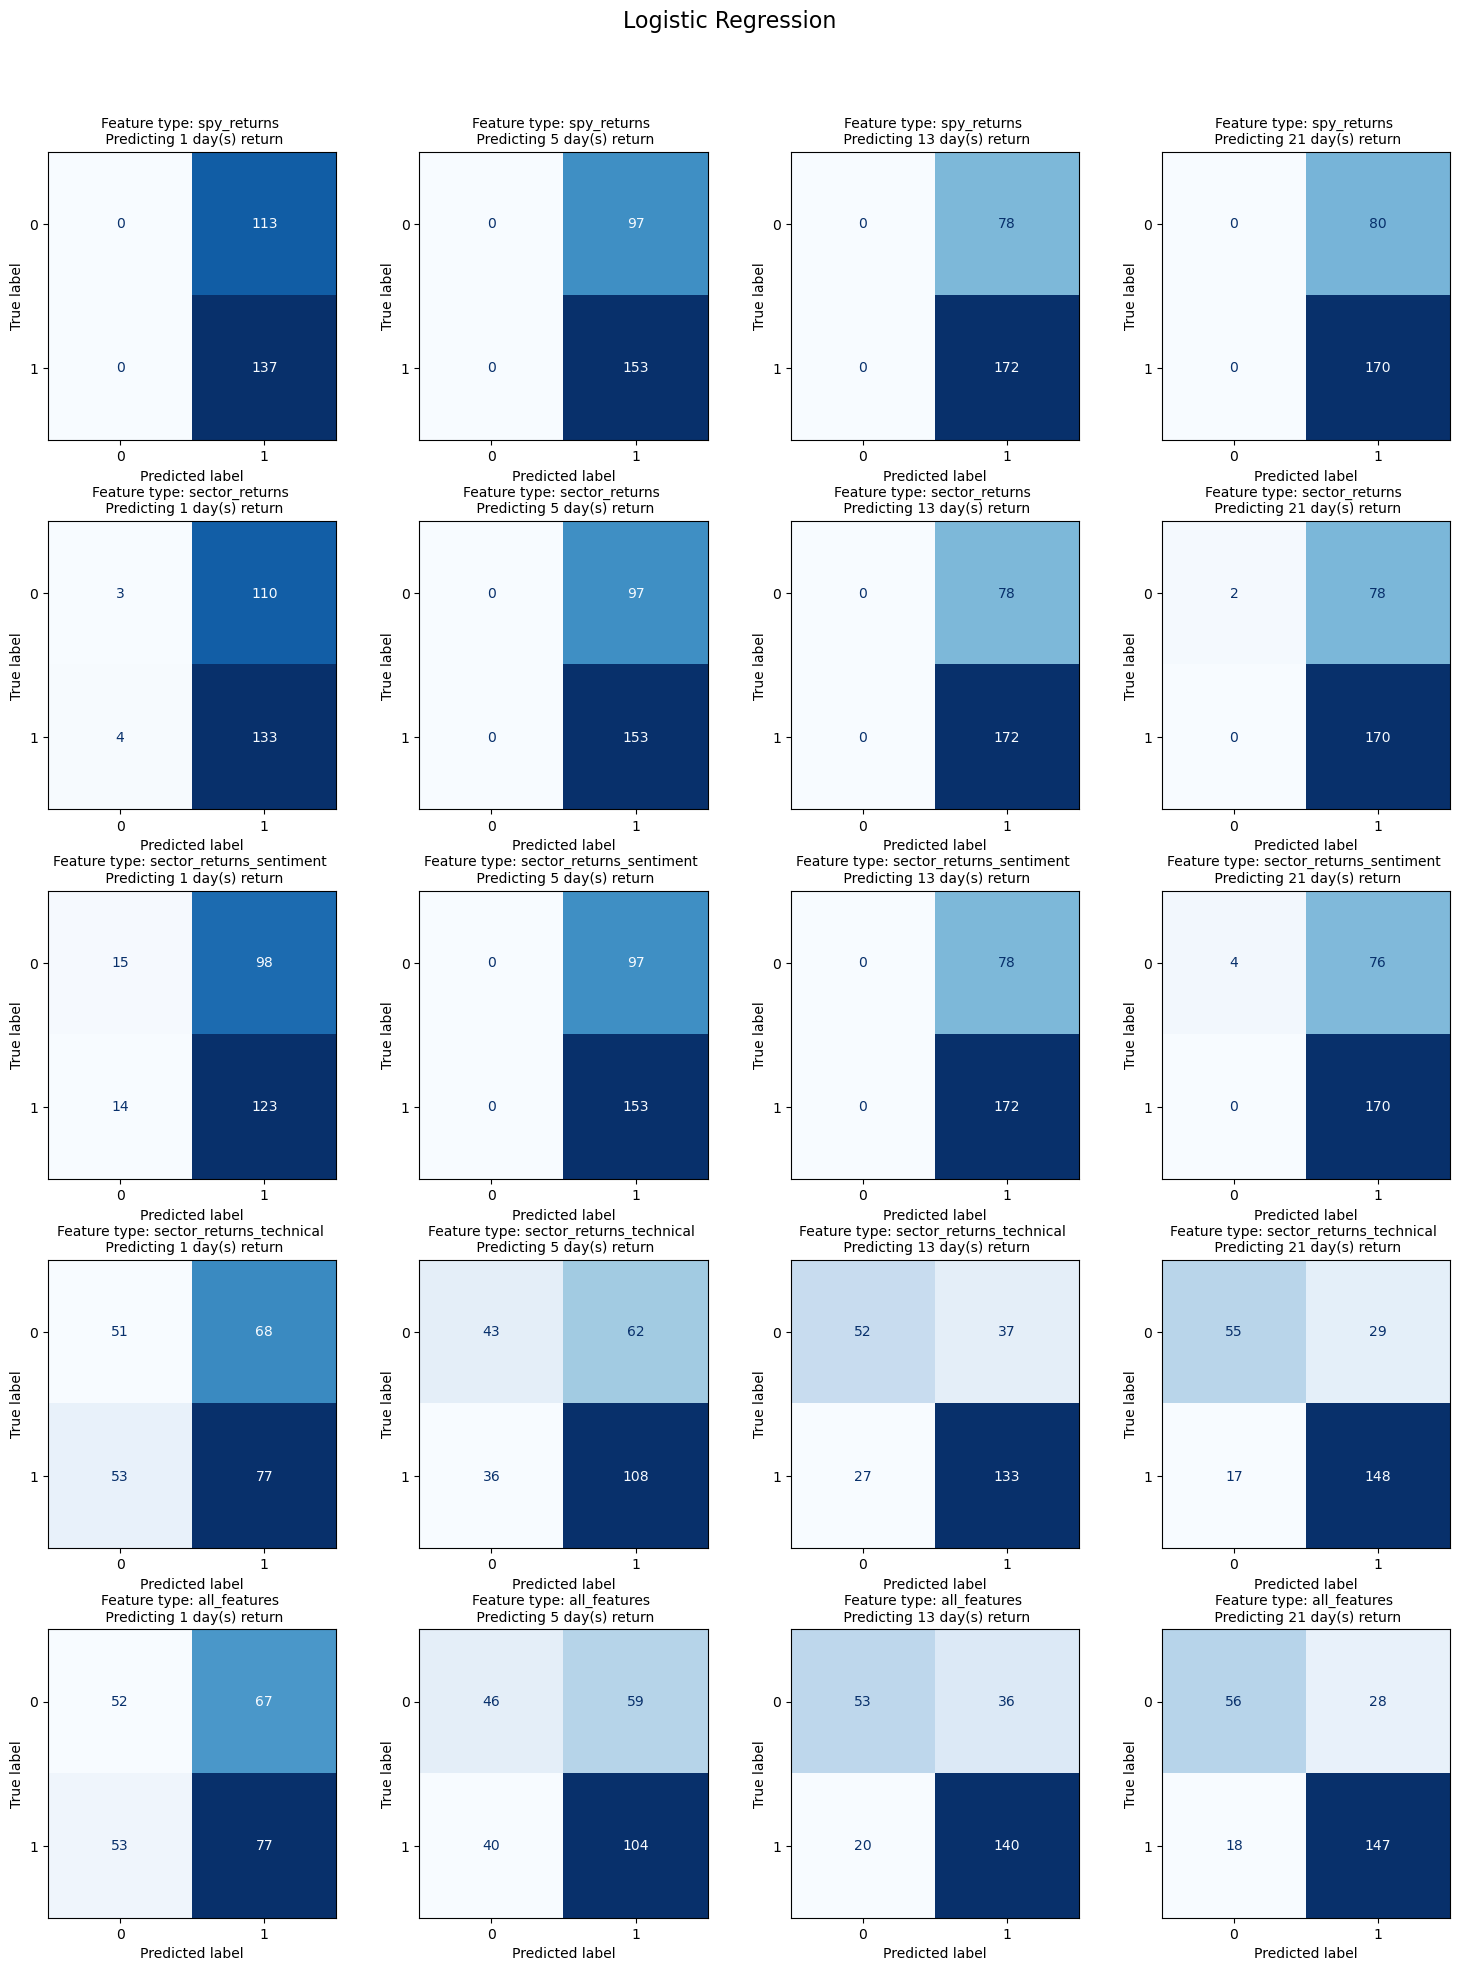

In [47]:
plot_all_confusion_matrices(models_key["logistic_regression"], "Logistic Regression")

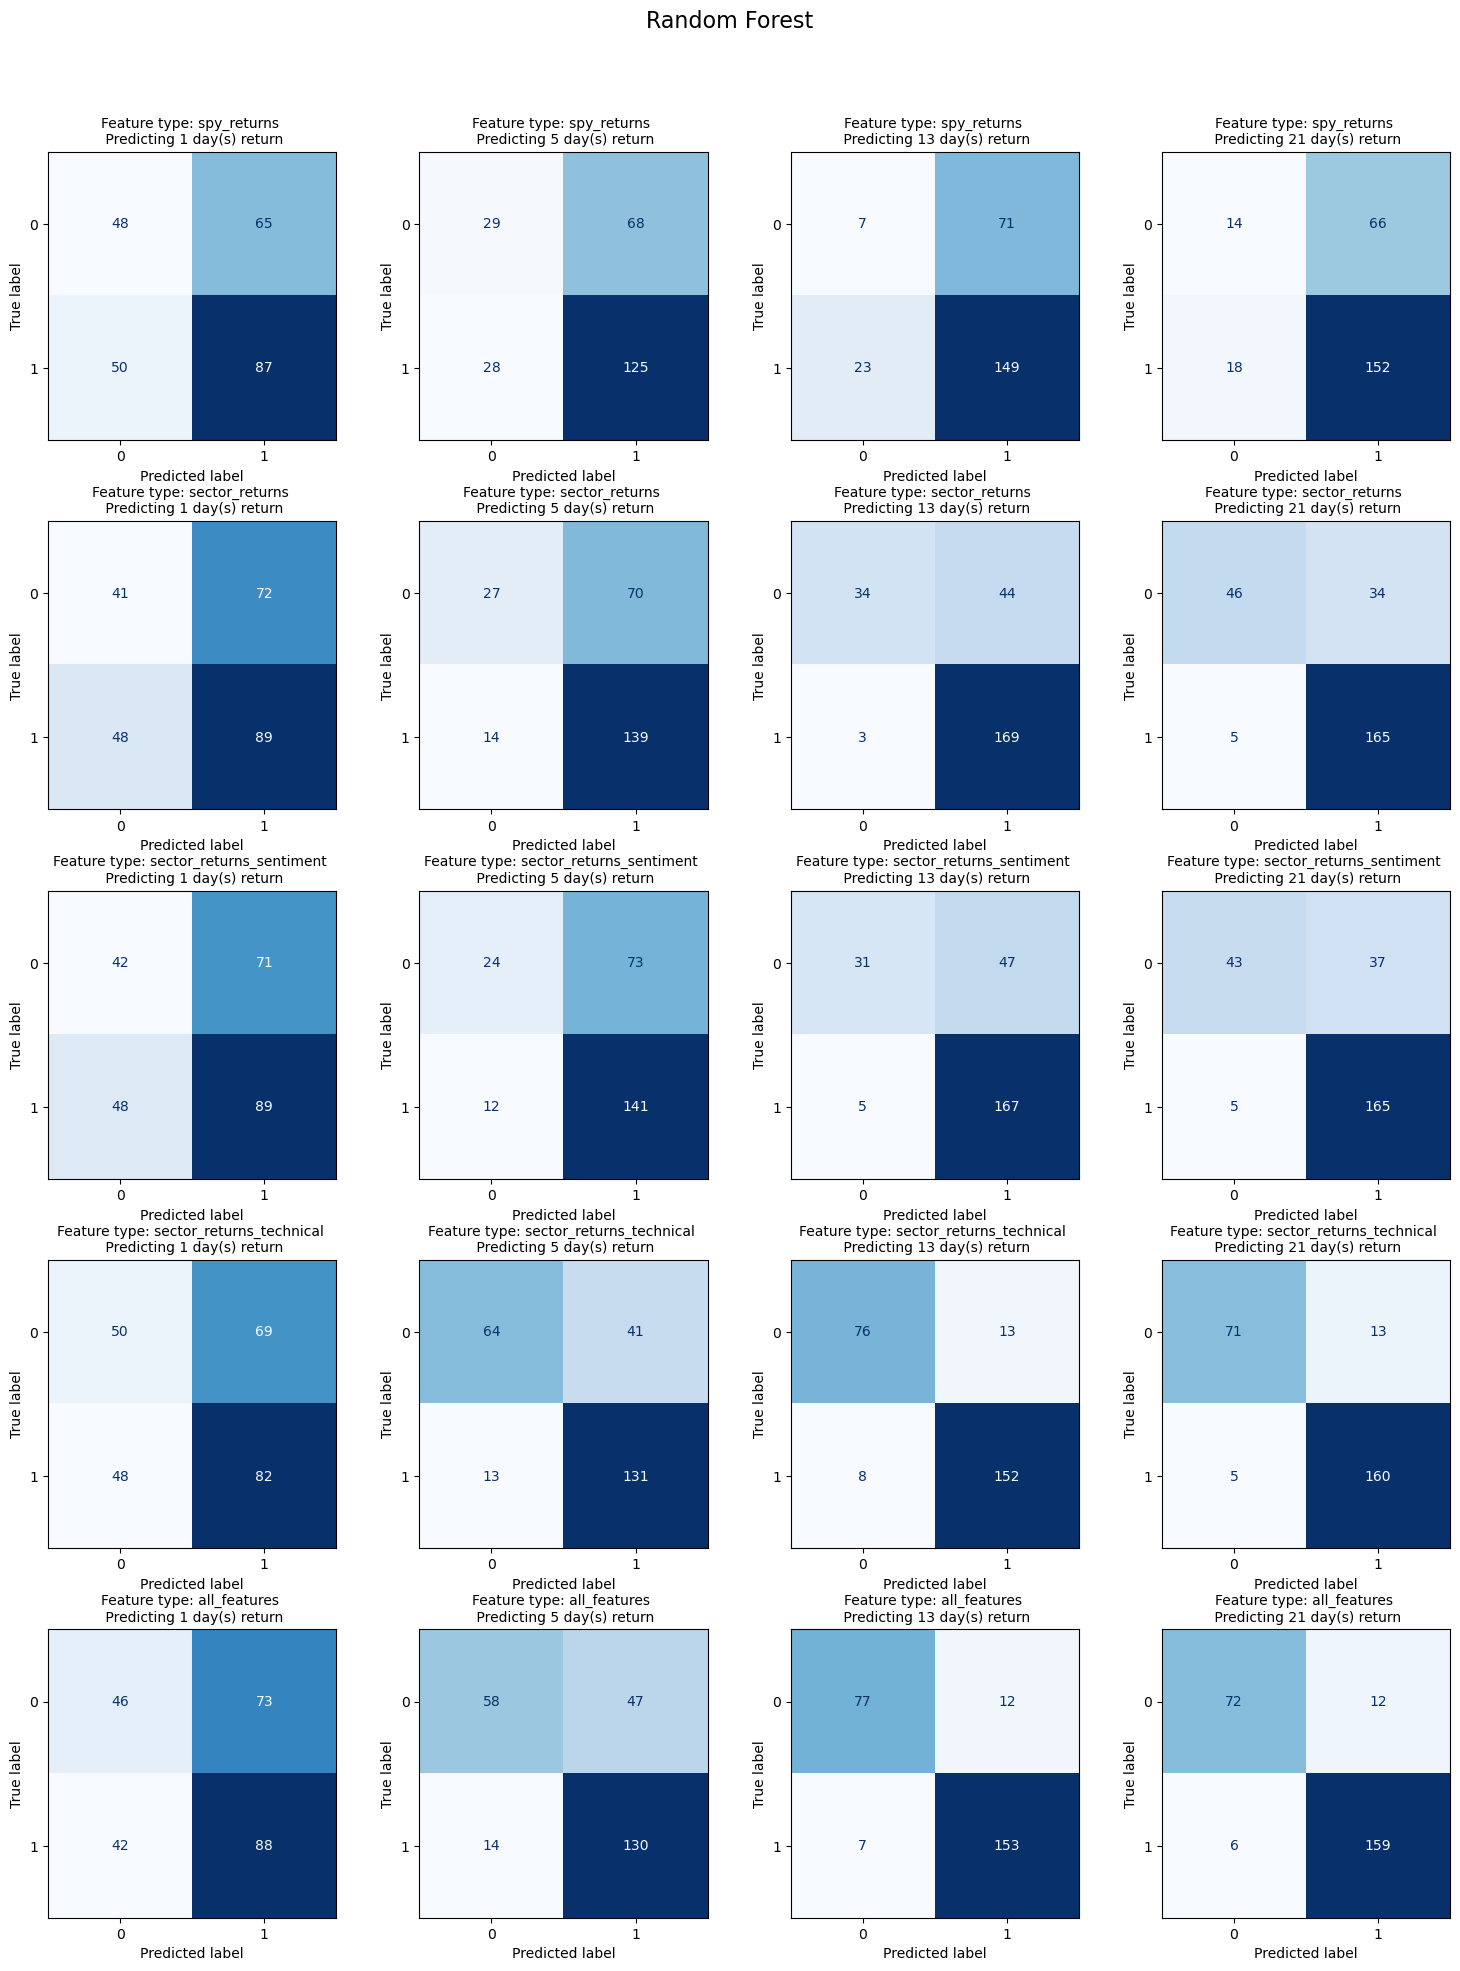

In [48]:
plot_all_confusion_matrices(models_key["random_forest"], "Random Forest")

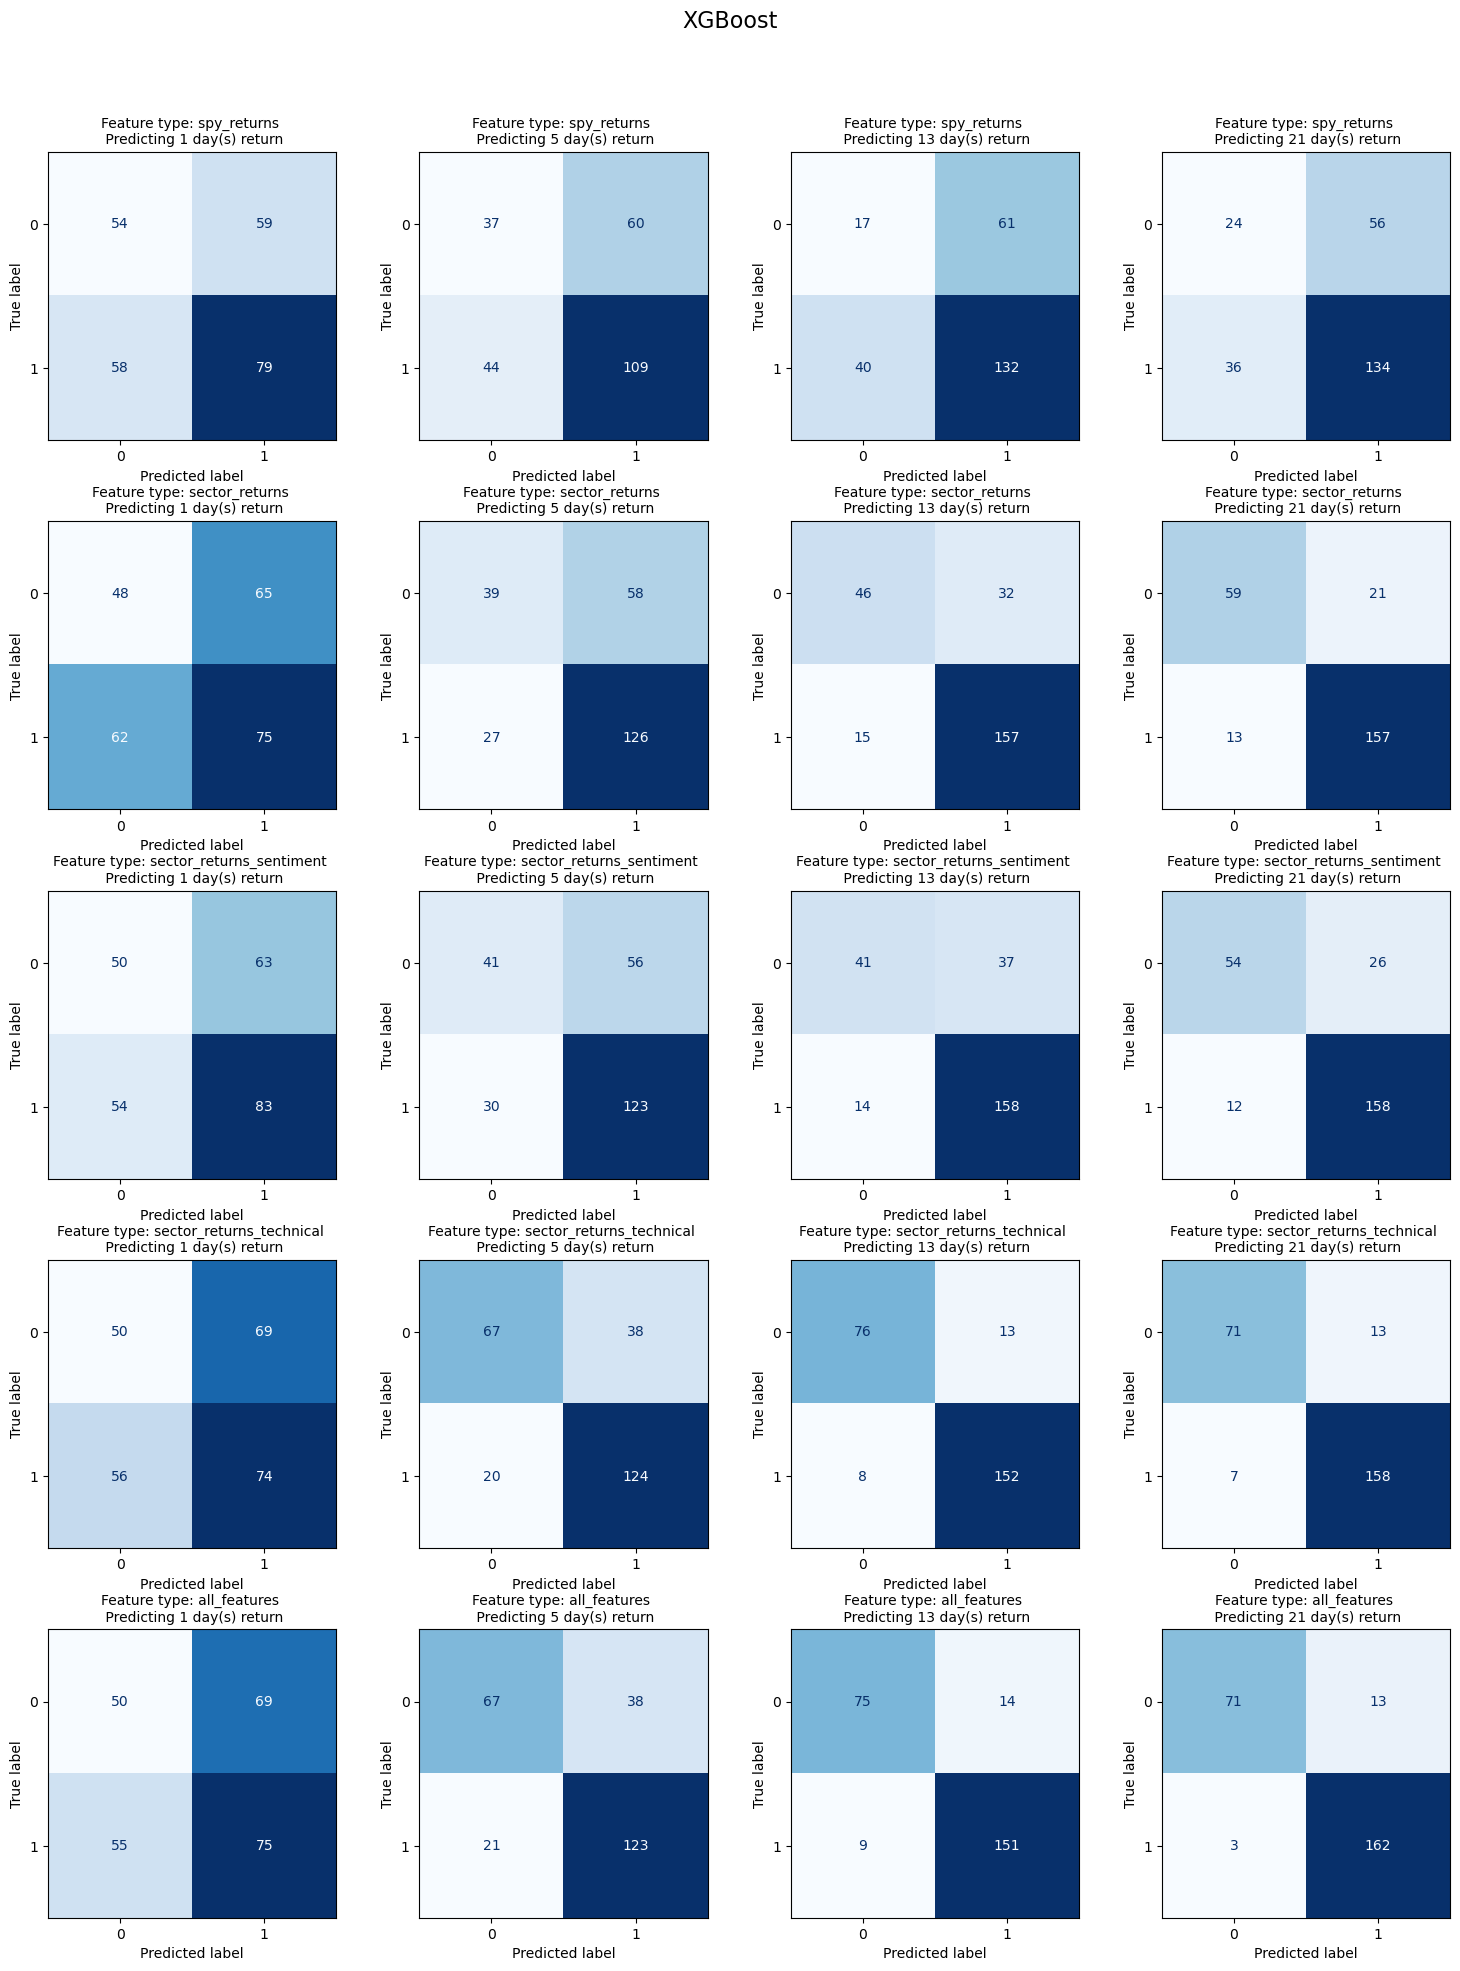

In [49]:
plot_all_confusion_matrices(models_key["xgboost"], "XGBoost")

### Input data sequentially

In [12]:
from utils import prep_classifier_data, feature_type_map

fm = feature_type_map(stocks)
columns1 = list(set(fm["spy_returns"]))
columns2 = list(set(fm["returns"]))
columns3 = list(set(fm["returns"] + fm["sentiment"]))
columns4 = list(set(fm["returns"] + fm["technical"]))
columns5 = stocks.columns


# dictionary to store tuple of (pred, confusion_matrix, classifier) for each day, for each feature type, for each model
models_key = {
    "logistic_regression": {
        "spy_returns": {1: None, 5: None, 13: None, 21: None},
        "sector_returns": {1: None, 5: None, 13: None, 21: None},
        "sector_returns_sentiment": {1: None, 5: None, 13: None, 21: None},
        "sector_returns_technical": {1: None, 5: None, 13: None, 21: None},
        "all_features": {1: None, 5: None, 13: None, 21: None},
    },
    "random_forest": {
        "spy_returns": {1: None, 5: None, 13: None, 21: None},
        "sector_returns": {1: None, 5: None, 13: None, 21: None},
        "sector_returns_sentiment": {1: None, 5: None, 13: None, 21: None},
        "sector_returns_technical": {1: None, 5: None, 13: None, 21: None},
        "all_features": {1: None, 5: None, 13: None, 21: None},
    },
    "xgboost": {
        "spy_returns": {1: None, 5: None, 13: None, 21: None},
        "sector_returns": {1: None, 5: None, 13: None, 21: None},
        "sector_returns_sentiment": {1: None, 5: None, 13: None, 21: None},
        "sector_returns_technical": {1: None, 5: None, 13: None, 21: None},
        "all_features": {1: None, 5: None, 13: None, 21: None},
    },
}

y_tests = {
    "spy_returns": {1: None, 5: None, 13: None, 21: None},
    "sector_returns": {1: None, 5: None, 13: None, 21: None},
    "sector_returns_sentiment": {1: None, 5: None, 13: None, 21: None},
    "sector_returns_technical": {1: None, 5: None, 13: None, 21: None},
    "all_features": {1: None, 5: None, 13: None, 21: None},
}

# loop through each day and each feature type
for i, day_no in enumerate([1, 5, 13, 21]):
    for j, features in enumerate([columns1, columns2, columns3, columns4, columns5]):
        features_type = [
            "spy_returns",
            "sector_returns",
            "sector_returns_sentiment",
            "sector_returns_technical",
            "all_features",
        ][j]

        # prep data
        X_train, X_test, y_train, y_test = prep_classifier_data(
            stocks[features].copy(), day_no, sequential=True
        )

        if y_tests[features_type][day_no] is None:
            y_tests[features_type][day_no] = y_test

        ## models
        from utils import (
            logistic_regression,
            random_forest_classifier,
            xgboost_classifier,
        )

        # logistic regression
        print(f"Logistic Regression on {day_no} day(s) with {features_type}...")
        models_key["logistic_regression"][features_type][day_no] = logistic_regression(
            X_train, X_test, y_train, y_test
        )

        # random forest
        print(f"Random Forest on {day_no} day(s) with {features_type}...")
        models_key["random_forest"][features_type][day_no] = random_forest_classifier(
            X_train, X_test, y_train, y_test
        )

        # xgboost
        print(f"XGBoost on {day_no} day(s) with {features_type}...")
        models_key["xgboost"][features_type][day_no] = xgboost_classifier(
            X_train, X_test, y_train, y_test
        )

Logistic Regression on 1 day(s) with spy_returns...
Accuracy: 0.59
Random Forest on 1 day(s) with spy_returns...
Accuracy: 0.52
XGBoost on 1 day(s) with spy_returns...
Accuracy: 0.48
Logistic Regression on 1 day(s) with sector_returns...
Accuracy: 0.58
Random Forest on 1 day(s) with sector_returns...
Accuracy: 0.47
XGBoost on 1 day(s) with sector_returns...
Accuracy: 0.50
Logistic Regression on 1 day(s) with sector_returns_sentiment...
Accuracy: 0.58
Random Forest on 1 day(s) with sector_returns_sentiment...
Accuracy: 0.46
XGBoost on 1 day(s) with sector_returns_sentiment...
Accuracy: 0.52
Logistic Regression on 1 day(s) with sector_returns_technical...
Accuracy: 0.47
Random Forest on 1 day(s) with sector_returns_technical...
Accuracy: 0.45
XGBoost on 1 day(s) with sector_returns_technical...
Accuracy: 0.46
Logistic Regression on 1 day(s) with all_features...
Accuracy: 0.45
Random Forest on 1 day(s) with all_features...
Accuracy: 0.47
XGBoost on 1 day(s) with all_features...
Accuracy: 

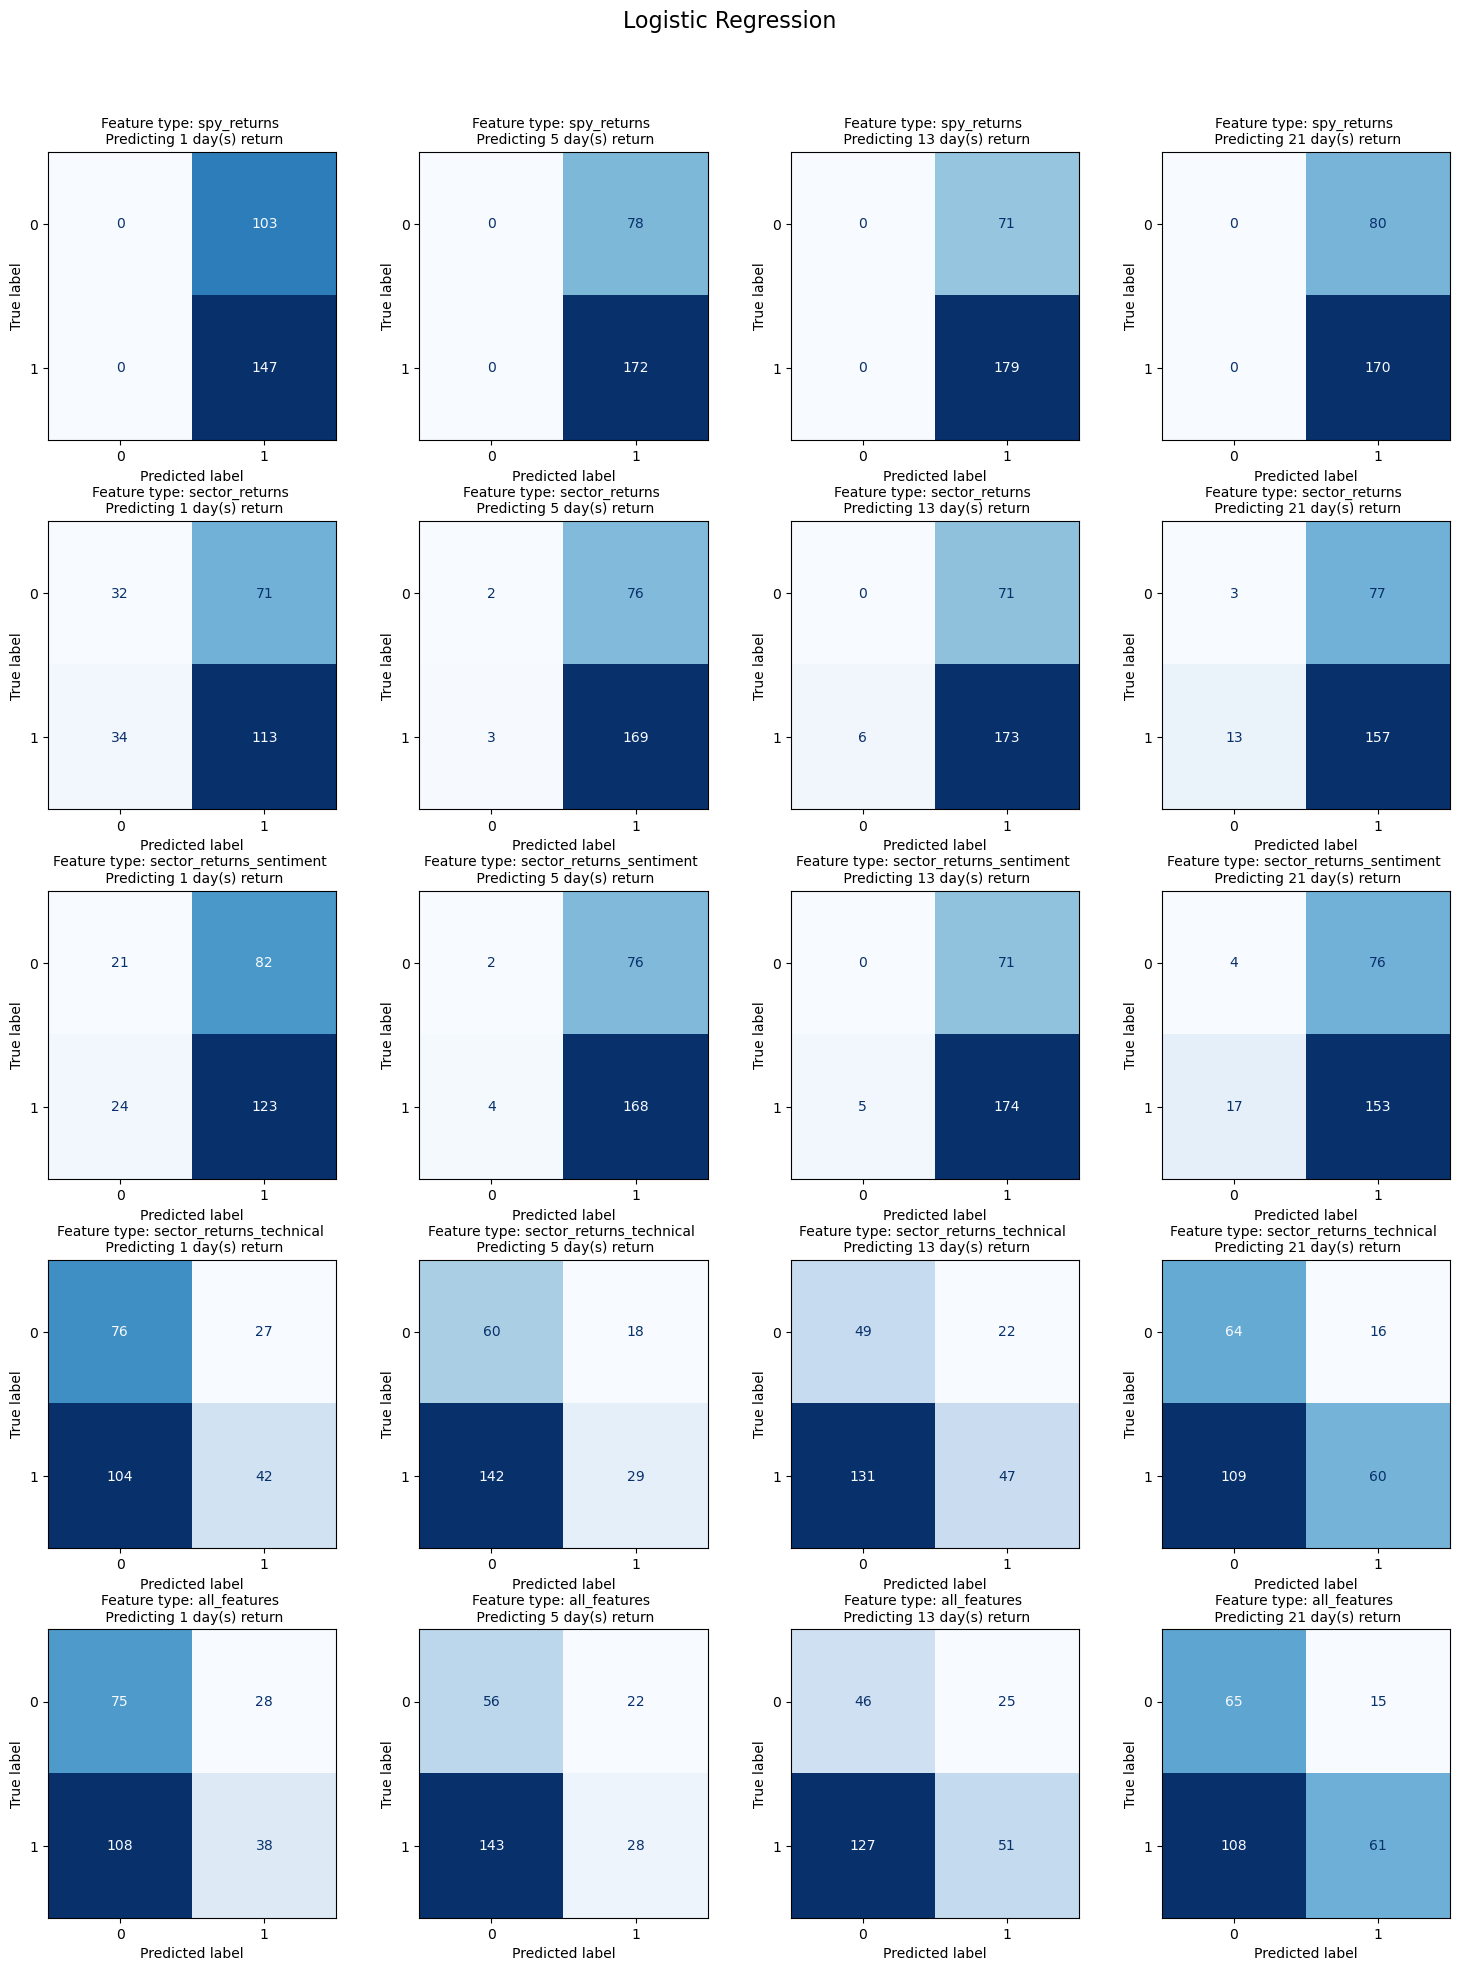

In [6]:
plot_all_confusion_matrices(models_key["logistic_regression"], "Logistic Regression")

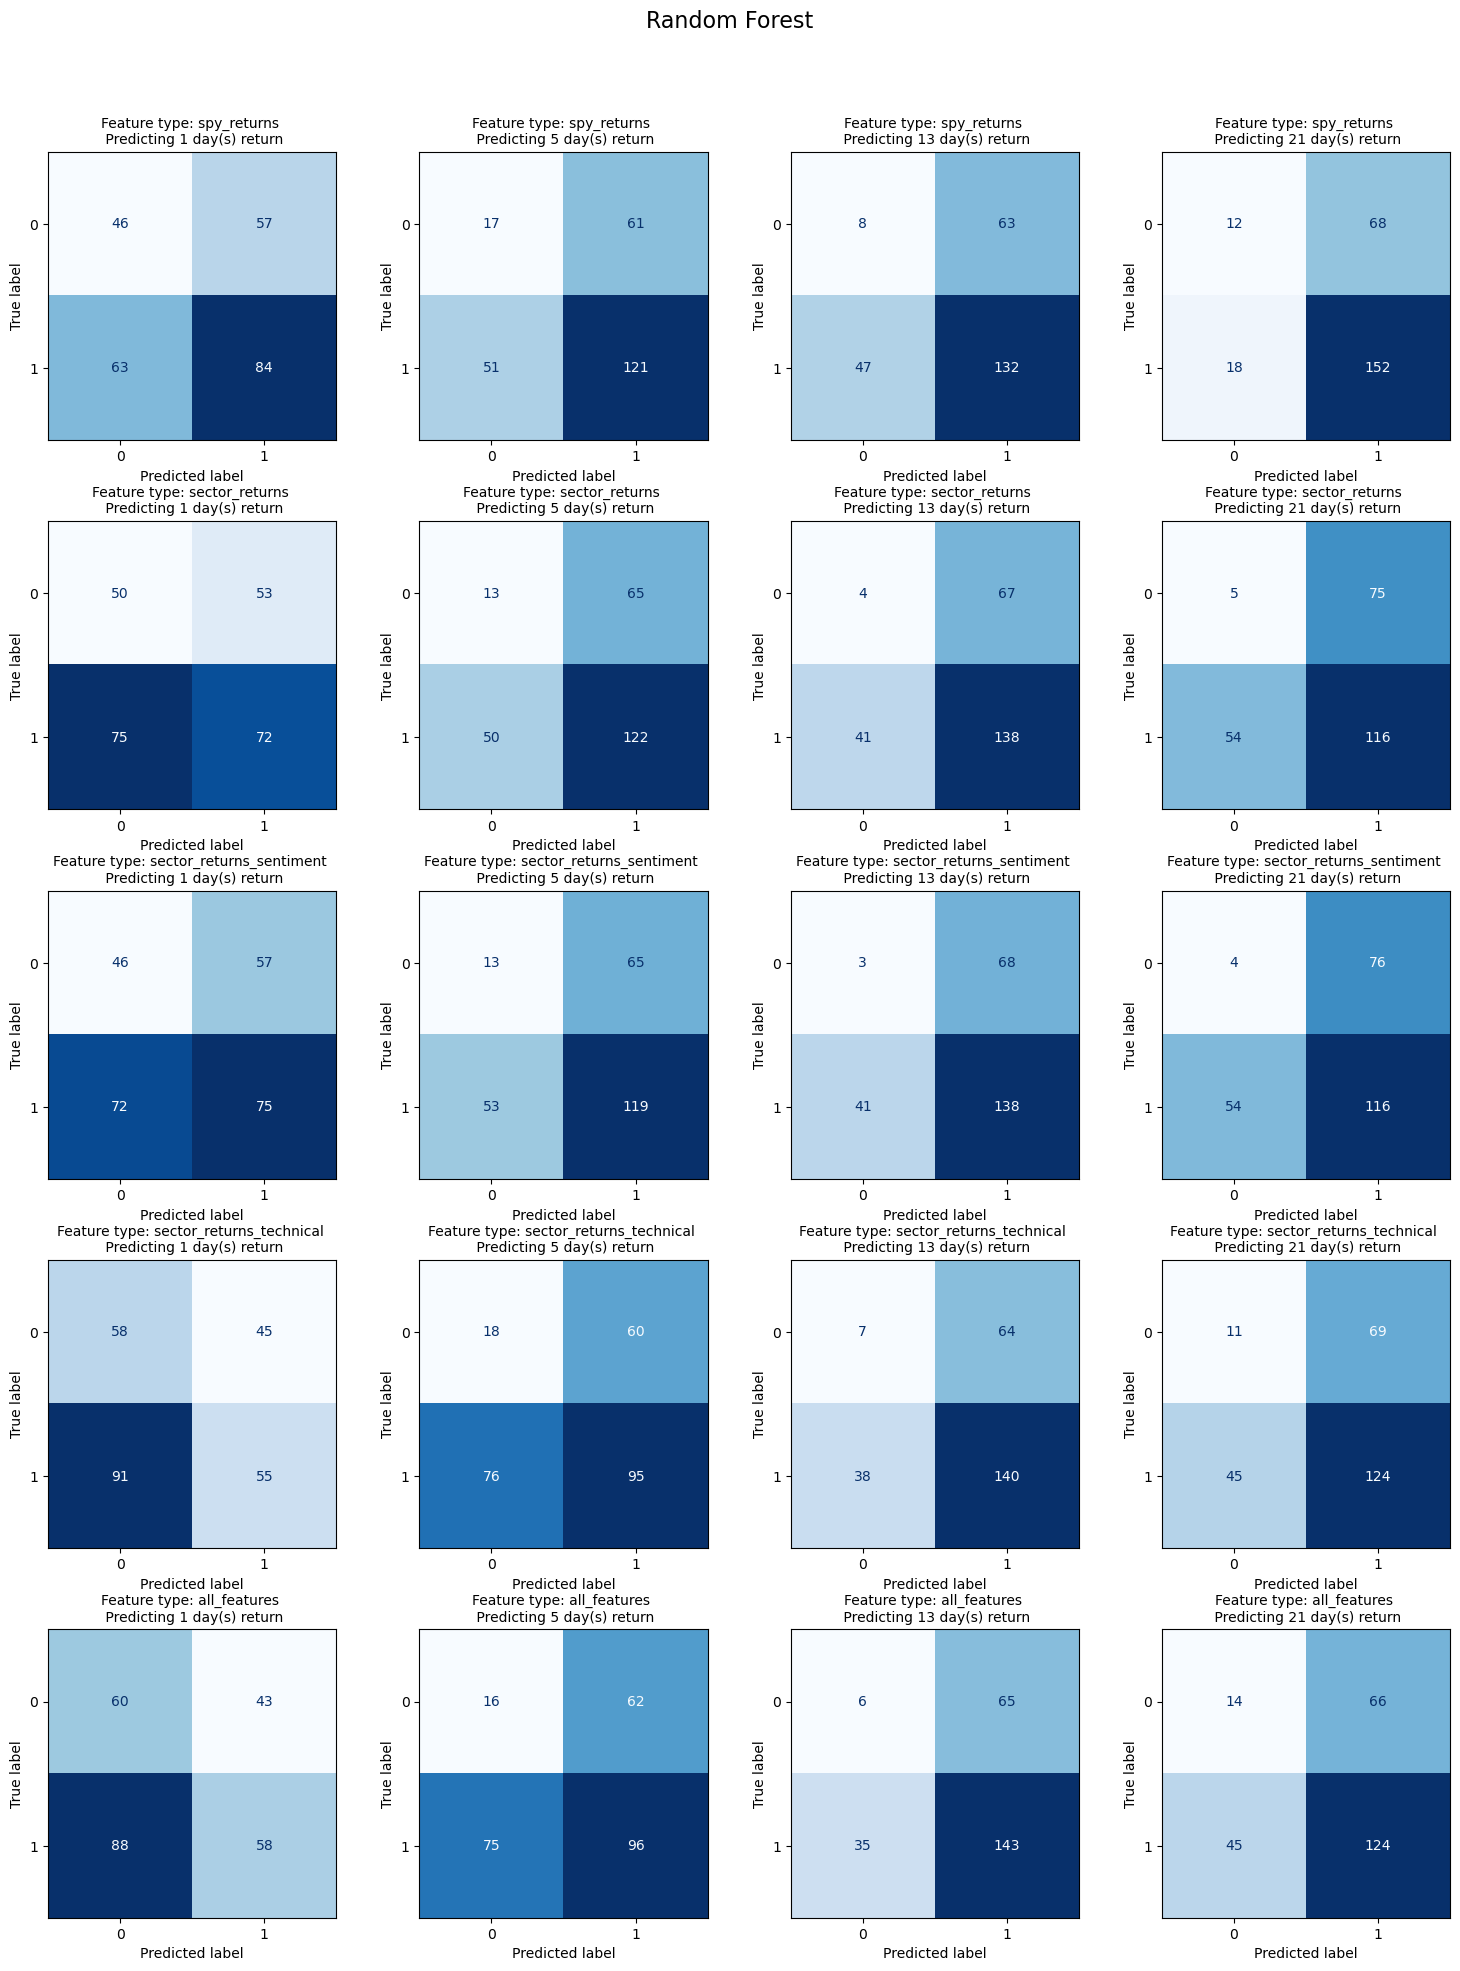

In [7]:
plot_all_confusion_matrices(models_key["random_forest"], "Random Forest")

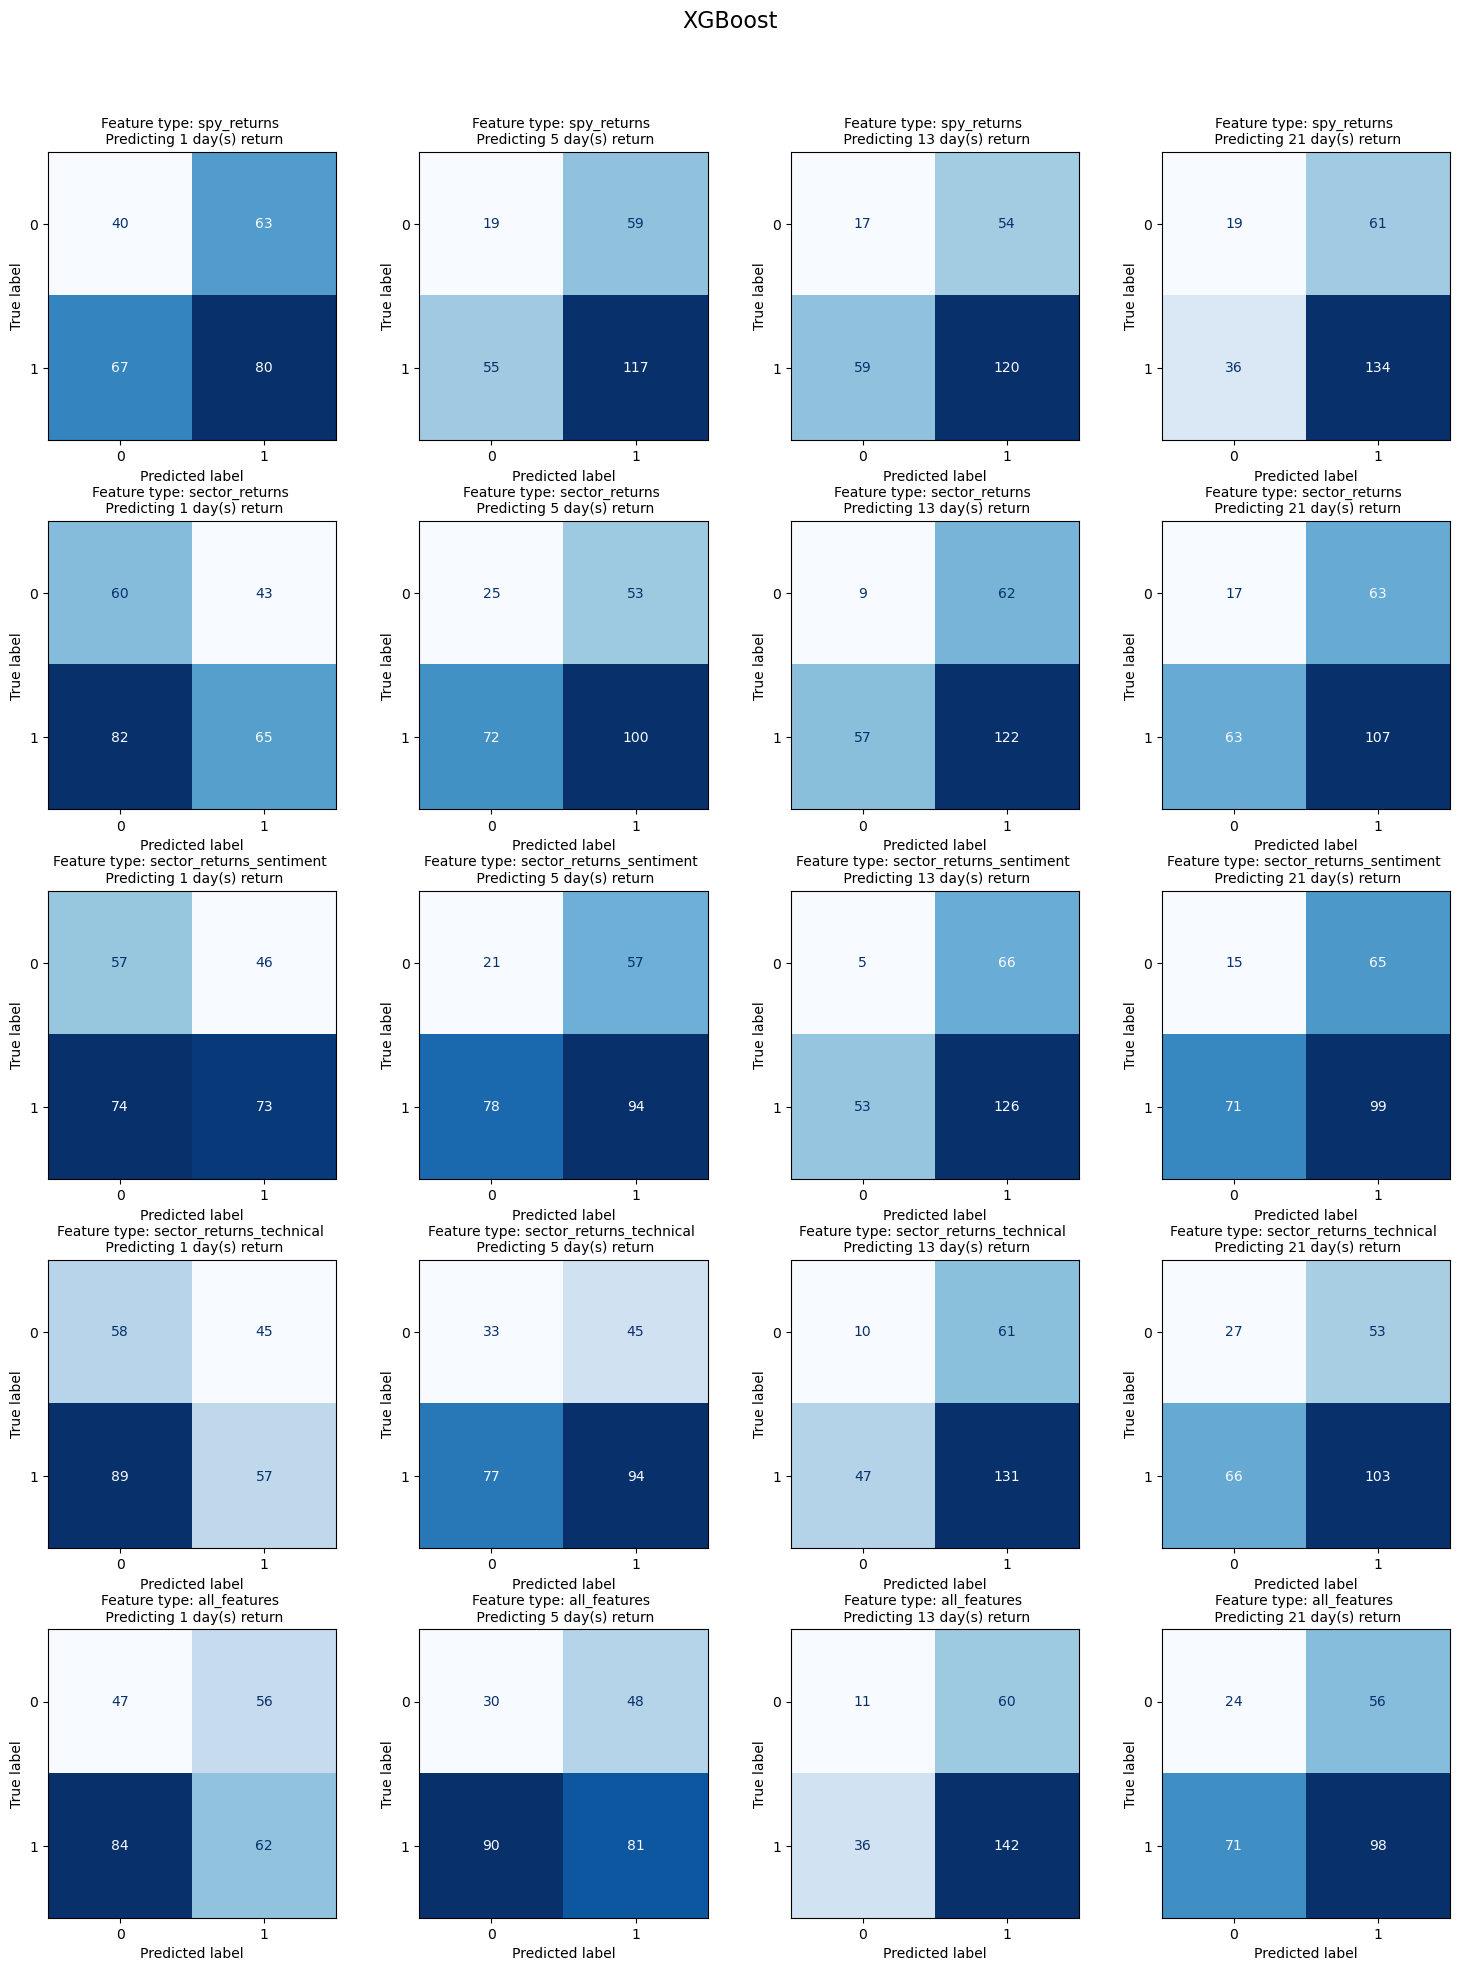

In [13]:
plot_all_confusion_matrices(models_key["xgboost"], "XGBoost")

In [ ]:
## feature importance
# random forest
from utils import (
    plot_feature_importance,
    prep_classifier_data,
    random_forest_classifier,
)

X_train, X_test, y_train, y_test = prep_classifier_data(
    stocks.copy(),
    21,
    sequential=False,
)

rf = random_forest_classifier(X_train, X_test, y_train, y_test)[2]

plot_feature_importance(rf, X_train, 21)


In [15]:
feature_importance = rf.feature_importances_
feature_names = np.arange(X_train.shape[1])
sorted_idx = feature_importance.argsort()[::-1]
stocks.columns[sorted_idx]


Index(['XLV_OPEN', 'XLU_ewm_log_ret_1d', 'XLU_macd_8d_slope', 'XBI_OPEN',
       'XLP_rsi_8d_slope', 'XLY_OPEN', 'XLK_ewm_log_ret_1d',
       'XOP_rsi_8d_slope', 'DATE', 'SPY_ewm_log_ret_1d',
       ...
       'SPY_ewm_log_ret_13d', 'XOP_ewm_log_ret_13d', 'SPY_macd_13d_slope',
       'XLI_log_ret_21d', 'XLI_rsi_13d_slope', 'XLE_HIGH',
       'SPY_3M IMPLIED VOL', 'SPY_log_ret_13d', 'XBI_HIGH', 'XRT_LOW'],
      dtype='object', length=420)

In [19]:
stocks.drop(columns=["DATE"]).columns[sorted_idx]

Index(['XLV_SHORT INTEREST RATIO', 'XLU_ewm_log_ret_21d', 'XLU_macd_sig',
       'XBI_SHORT INTEREST RATIO', 'XLU_3M IMPLIED VOL',
       'XLY_SHORT INTEREST RATIO', 'XLK_ewm_log_ret_21d', 'XRT_3M IMPLIED VOL',
       'SPY_3M IMPLIED VOL', 'SPY_ewm_log_ret_21d',
       ...
       'SPY_ewm_log_ret_1d', 'XOP_ewm_log_ret_1d', 'SPY_macd_1d_slope',
       'XLI_log_ret_3d', 'XLI_rsi_1d_slope', 'XLE_LOW', 'SPY_HIGH',
       'SPY_log_ret_1d', 'XBI_LOW', 'XRT_OPEN'],
      dtype='object', length=420)

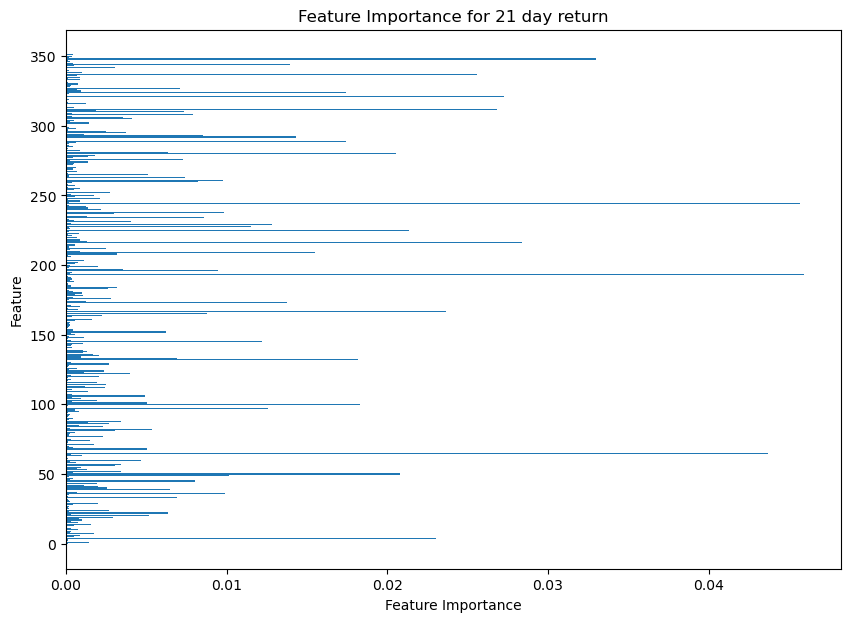

In [15]:
from utils import plot_feature_importance

plot_feature_importance(xgb, X_train, 21)


In [16]:
feature_importance = xgb.feature_importances_
feature_names = np.arange(X_train.shape[1])
sorted_idx = feature_importance.argsort()[::-1]
stocks.drop(columns=["DATE"]).columns[sorted_idx]


Index(['XLP_OPEN', 'XLU_ivol_8d_slope', 'XBI_macd_3d_slope',
       'XOP_ewm_log_ret_1d', 'XLP_macd_21d_slope', 'XLY_log_ret_13d',
       'XLY_ewm_log_ret_3d', 'XLY_rsi_1d_slope', 'XLK_ivol_5d_slope',
       'SPY_SHORT INTEREST RATIO',
       ...
       'XLI_macd_21d_slope', 'SPY_ivol_1d_slope', 'XLV_rsi_21d_slope',
       'XLP_ivol_3d_slope', 'XLE_3M IMPLIED VOL', 'XLY_macd_5d_slope',
       'XLK_log_ret_3d', 'XLE_rsi_13d_slope', 'XLU_ewm_log_ret_3d', 'XLV_LOW'],
      dtype='object', length=352)

In [17]:
stocks.drop(columns=["DATE"]).columns[sorted_idx[:50]]

Index(['XLP_OPEN', 'XLU_ivol_8d_slope', 'XBI_macd_3d_slope',
       'XOP_ewm_log_ret_1d', 'XLP_macd_21d_slope', 'XLY_log_ret_13d',
       'XLY_ewm_log_ret_3d', 'XLY_rsi_1d_slope', 'XLK_ivol_5d_slope',
       'SPY_SHORT INTEREST RATIO', 'XLP_rsi_3d_slope', 'XBI_ivol_1d_slope',
       'XLV_ivol_3d_slope', 'XLE_macd_13d_slope', 'XLI_log_ret_1d', 'XLV_macd',
       'XLY_log_ret_3d', 'XLP_log_ret_21d', 'XLV_macd_21d_slope', 'XOP_LOW',
       'XLK_log_ret_5d', 'XLU_HIGH', 'XLE_log_ret_5d', 'XLI_rsi',
       'XLU_3M IMPLIED VOL', 'XBI_ivol_13d_slope', 'SPY_rsi_5d_slope',
       'XLU_ewm_log_ret_8d', 'XLU_rsi_1d_slope', 'XLP_ewm_log_ret_1d',
       'XLK_ivol_21d_slope', 'XLU_ewm_log_ret_1d', 'XLV_macd_3d_slope',
       'XLU_rsi_13d_slope', 'XBI_ewm_log_ret_21d', 'XLY_SHORT INTEREST RATIO',
       'XLU_rsi_3d_slope', 'XLY_ewm_log_ret_1d', 'XLV_ewm_log_ret_8d',
       'XLY_macd', 'XLI_log_ret_21d', 'SPY_rsi_1d_slope', 'XBI_HIGH',
       'XLV_ivol_5d_slope', 'SPY_log_ret_8d', 'XLK_3M IMPLIED VOL'

In [28]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=1, hidden_layer_sizes=(720, 720, 720))
mlp.fit(X_train, y_train)
mlp.score(X_test, y_test)


from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, mlp.predict(X_test))


array([[ 16,  64],
       [ 44, 125]], dtype=int64)

In [29]:
# accuracy
from sklearn.metrics import accuracy_score

accuracy_score(y_test, mlp.predict(X_test))


0.5662650602409639

Add technical indicators for sentiment